# Stutil tools demonstration


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import random
import skimage.io
import os

from structure_tensor import eig_special_3d, structure_tensor_3d
import scmap

import stutil.volume, stutil.glyph


First, an example struture tensor calculation is necessary. Here, a small fragment of mozzarella CT scan is used. The same can be also done on randomly generated data, but the result is less informative.

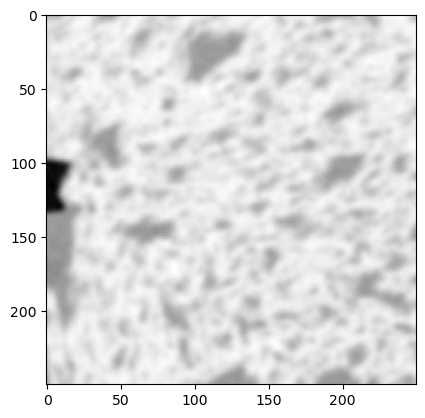

In [15]:
# Load example date
volume = skimage.io.imread("./vol.tiff").astype("float")
# Optional, generate random data
# volume = np.random.rand(100, 100, 100)

slice_idx = 100
plt.imshow(volume[:,:,slice_idx], cmap='gray')

Apart from structure tensor, it may be useful to calculate some anisotropy measure, e.g. Fractional Anisotropy. It can later be used as a weighting factor, to better represent the data.

In [16]:
# Structure tensor
sigma = 1.5
rho = 5.5

S = structure_tensor_3d(volume, sigma, rho)
val, vec = eig_special_3d(S)

#Fractional anisotropy
meanVal = np.mean(val, axis=0)
anis = (np.sqrt(3 / 2) * np.sqrt((val[0] - meanVal) ** 2 + (val[1] - meanVal) ** 2 + (val[2] - meanVal) ** 2)
        / np.sqrt(val[0] ** 2 + val[1] ** 2 + val[2] ** 2))


Calculated structure orientation can be visualized with color, where each direction (ideally) has a unique color assigned to it.

There are many approaches to the color scheme choice, none of them perfect. The most universally applicable is using an icosahedron (visualized below). For details see: https://github.com/vedranaa/sphere-colormap


In [17]:
u = np.linspace(0, 2 * np.pi, 80)
v = np.linspace(0, np.pi, 80)

# create the sphere surface
x=1* np.outer(np.cos(u), np.sin(v))
y=1* np.outer(np.sin(u), np.sin(v))
z=1* np.outer(np.ones(np.size(u)), np.cos(v))

vec_sphere = np.array([x,y,z])

myheatmap = stutil.volume.convertToIco(np.expand_dims(vec_sphere,-1))

Text(0.5, 0.92, 'Icosahedron coloring scheme')

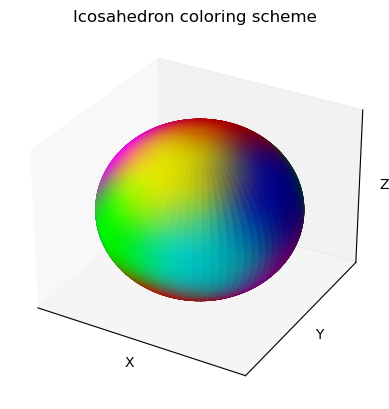

In [18]:
# %matplotlib widget # Use this for interactive plots
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.plot_surface(x, y, z, cstride=1, rstride=1, facecolors=np.moveaxis(myheatmap,0,-1))
ax.set_xlabel('X', labelpad=-10)
ax.set_ylabel('Y', labelpad=-10)
ax.set_zlabel('Z', labelpad=-10)
ax.grid(False)

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.set_title("Icosahedron coloring scheme")

The coloring can be applied to each pixel in the volume, allowing for inspection of spatial orientation distribution.

Additionally, there is an option to include a weighting factor. It will be applied to the Alpha channel of the color map. Intuitively, an anisotropy measure is a good fit, as low anisotropy orientations are not as influential, so they can be ignored.

In [19]:
rgba = stutil.volume.convertToIco(vec, weights=anis)

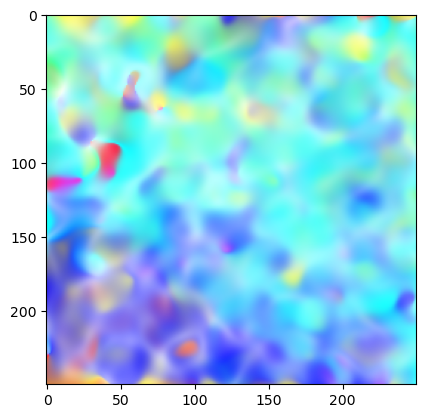

In [20]:
slice_idx = 100
plt.imshow(np.moveaxis(rgba[:,:,:,slice_idx],0,-1))

Generated volume can be saved in chosen format. Stutil provides a function for saving it as .tiff that will be displayed correctly in ParaView.

In [21]:
stutil.volume.saveRgbaVolume(rgba, savePath='./orient_rgba.tiff')

It often is useful to inspect a histogram of the orientations. In this case that is a 2D histogram split along longitudinal nad lattitudinal lines on a sphere.

In case of structure tensor, we only care about orientation, and not direction, so a half of a sphere is enough to describe the variability in the data. Nevertheless, it is typical to still use the whole sphere, as it generates better visualizations.

Here again it is possible to weight the importance of each orientation by some measure. Again, a natural choice for that is anisotropy.

An important step in calculating the histogram on a sphere is accounting for the size of bins, that get much smaller close to the poles (binArea flag). Typically, a histogram is also normalized to sum up to 1 in order to become invariant to the amount of provided vectors (prob flag).

In [22]:
fullSphere = True
sph, sph_anis = stutil.glyph.orientationVec(vec.reshape(3, -1), fullSphere=fullSphere, weights=anis.ravel())

H, el, az, binArea = stutil.glyph.histogram2d(sph, bins=[100, 200], norm="prob_binArea", weights=sph_anis)



The easiest way to visualize any 2D histogram is with an image, but in the case of spherical data it isn't very easy to interpret.

Text(0.5, 1.0, 'Orientation histogram')

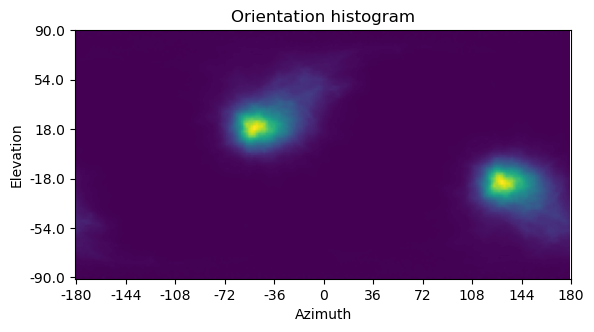

In [23]:
el_ticks  = np.linspace(-90, 90, 6)
if fullSphere:
    az_ticks = np.linspace(-180, 180, 11).astype(int)
else:
    az_ticks = np.linspace(-90, 90, 11).astype(int)

plt.figure()
plt.imshow(H, origin="lower")
plt.xticks(np.arange(0,201,20),az_ticks)
plt.yticks(np.arange(0,101,20),el_ticks)
plt.xlabel("Azimuth")
plt.ylabel("Elevation")
plt.title("Orientation histogram")

As an alternative, a visualization with a gluph can be used - A sphere that is elongated to a degree corresponding to a value in each bin. Here the glyph is also colored so that it corresponds to the colors in the RGBA volume. By comparing  both visualizations, you can decipher the orientation of any part of the volume and judge its influence on the orientation of the whole structure.

In [24]:
XYZ, RGB = stutil.glyph.generate_glyph(H, el, az, np.array([0, 0]), flipColor=fullSphere)

[]

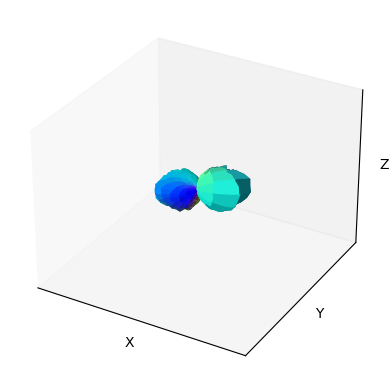

In [25]:
# %matplotlib widget
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

face_colors = np.moveaxis(RGB,0,-1)    
ax.plot_surface(XYZ[0],XYZ[1],XYZ[2],facecolors=face_colors)

ax.set_xlabel('X', labelpad=-10)
ax.set_ylabel('Y', labelpad=-10)
ax.set_zlabel('Z', labelpad=-10)
ax.grid(False)

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

The glyph can be saved in .VTK format, that again can be easily opened in ParaView. 

In [26]:
stutil.glyph.save_glyph(XYZ, RGB, "./glyph.vtk")